# Exploring the orbits of binaries in star clusters

## Goals and the plan

In this case study we're going to explore ``cogsworth``'s ability to handle hydrodynamical zoom-in simulations and demonstrate how binary interactions can dramatically change their evolution within a cluster. In particular, let's consider **"How do supernovae in binaries change their orbits within a star cluster?"**

In [711]:
import cogsworth
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection

In [707]:
# this all just makes plots look nice
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## Prepare and process the snapshot for use

First, we need to process a FIRE snapshot for use in our simulations. I'm going to re-use some of the code from the tutorials to prepare the $z = 0$ snapshot from the FIRE m11h simulation. You can find this snapshot online [in the FlatHub database](https://flathub.flatironinstitute.org/fire) and download it yourself!

In [5]:
snap = cogsworth.hydro.utils.prepare_snapshot("../../data/snapshot_600.hdf5")

cogsworth warning: Looks like you're loading a snapshot that doesn't specify its units, I'm going to infer them but make sure the outputted units looks right!


cogsworth warning: I couldn't find a halo catalogue, so I'll use pynbody's built-in halo finder to centre the snapshot


### Computing the potential

In [ ]:
pot = cogsworth.hydro.potential.get_snapshot_potential(snap)

### Rewinding star particles to formation

In [16]:
recent_stars = snap.s[(snap.properties["time"] - snap.s["tform"]).in_units("Myr") < 150]
recent_stars

<SimSnap "../../data/snapshot_600.hdf5::star:indexed" len=10232>

In [ ]:
init_particles = cogsworth.hydro.rewind.rewind_to_formation(recent_stars, pot)

## Simulate the galaxy evolution with ``cogsworth``

This is a big cell which would take a **long** time to run (hours on a laptop likely). You're perfectly welcome to run a larger simulation like this on your own, but in our case we're going to hone in on just one star particle to make this tractable for a laptop :D

In [238]:
# create a new HydroPopulation
p = cogsworth.hydro.pop.HydroPopulation(
    star_particles=init_particles,
    galactic_potential=pot,
    cluster_radius=3 * u.pc,
    cluster_mass=10000 * u.Msun,
    virial_parameter=1.0,
    max_ev_time=13.736521 * u.Gyr,
    m1_cutoff=0,
    processes=6
)
p.create_population()

### Focusing on just one star particle

Let's make some simple conditions to find a nice star particle. It would be nice if it was formed relatively recently (shorter orbits = faster), with a fairly low mass (fewer sampled binaries = faster) and not too close to the galactic centre (simpler orbits = faster).

Of course you might want to change these conditions to be optimised for more than just runtime!

In [646]:
recent = snap.properties["time"].in_units("Gyr") - init_particles["t_form"] < 45 / 1000
but_not_too_recent = snap.properties["time"].in_units("Gyr") - init_particles["t_form"] > 40 / 1000
low_mass = init_particles["mass"] < 6000
nice_spot = ((init_particles["x"]**2 + init_particles["y"]**2)**0.5 > 5) & (abs(init_particles["z"]) < 2)
init_particles[recent & but_not_too_recent & low_mass & nice_spot].sort_values("t_form", ascending=True)

,id,mass,Z,t_form,x,y,z,v_x,v_y,v_z
930,7231424,5768.237339,0.009172,13.692803,4.574098,2.348680,0.044659,-89.862373,84.257595,-24.269460
6023,4152982,5875.235044,0.012729,13.693178,-5.368502,-4.737183,-0.085027,6.224090,-101.217743,4.733644
3432,5859478,5938.063322,0.016559,13.693446,-3.025907,-6.940756,1.076242,78.552327,-44.146370,-1.410880
3434,1942518,5627.987070,0.013094,13.693581,-3.029216,-6.902082,1.078949,77.865572,-44.611424,-4.768456
6004,10681321,5724.979497,0.012728,13.693850,-5.505565,-4.656169,-0.143759,29.948241,-104.545041,6.718125
7364,2979855,5980.654508,0.010288,13.694016,5.941398,2.794227,0.021122,-59.325882,84.707950,7.470200
7546,11912307,5969.536186,0.013675,13.694386,-6.482726,1.239173,-0.424132,-43.878863,-82.543928,0.267864
6702,7068939,5753.248649,0.005498,13.695323,-4.758554,-6.343144,0.271053,60.862610,-84.494613,0.240775
201,10608011,5736.040976,0.012893,13.695389,-5.828201,-5.502802,0.474873,24.407445,-117.332655,15.006145
7615,6186453,5991.949629,0.014638,13.695389,-5.416391,-4.798061,-0.211719,5.015317,-91.541480,-1.131827


### Reduce to a subset of the binaries in the star particle

For some reason star particle 7546 speaks to me in this list so let's run that one for all masses and timesteps of 0.5 Myr. We're also proceed like this:

- Sample the binaries
- Do the stellar evolution
- Pick out all of the kicked systems and a subset that don't get kicks
- Evolve those ones

This saves us running orbits for lots of binaries that don't get kicks (whose orbits are all pretty similar anyway)

In [554]:
# create a new HydroPopulation
p = cogsworth.hydro.pop.HydroPopulation(
    star_particles=init_particles.loc[[7546]],
    galactic_potential=pot,
    cluster_radius=3 * u.pc,
    cluster_mass=10000 * u.Msun,
    virial_parameter=1.0,
    max_ev_time=13.736521 * u.Gyr,
    m1_cutoff=0,
    processes=6,
    timestep_size=0.5 * u.Myr
)

In [647]:
# sample and evolve the binaries
p.sample_initial_binaries()
p.perform_stellar_evolution()

In [556]:
# extract the kicked binaries and 500 non-kicked binaries
kicked_bin_nums = p.bpp[p.bpp["evol_type"].isin([15, 16])]["bin_num"].unique()
unkicked_bin_nums = p.bin_nums[~np.isin(p.bin_nums, kicked_bin_nums)]
bin_nums = np.sort(np.concatenate([kicked_bin_nums,
                           np.random.choice(unkicked_bin_nums, 500, replace=False)]))
p = p[bin_nums]

In [557]:
# evolve their orbits
p.perform_galactic_evolution()

520it [00:13, 38.71it/s]                         


## Create a plotting function

Let's make a nice function that let's use explore the cluster for different subsets of systems.

In [522]:
# YOU CAN SKIP OVER THIS CELL, IT'S ALL STYLING
# ---------------------------------------------

def add_stars(ax, starsurfacedensity=0.8, lw=1, starcolor="white", zorder=-1):
    """Don't worry too much about this function.
    It just adds a bunch of fake stars to the background of the plot (ain't it pretty)."""
    area = np.sqrt(np.sum(np.square(ax.transAxes.transform([1.,1.]) - ax.transAxes.transform([0.,0.]))))*1
    nstars = int(starsurfacedensity*area)

    #small stars
    xy = np.random.uniform(size=(nstars,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.05, s=8*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=4*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.2, s=0.5*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)

    #large stars
    xy = np.random.uniform(size=(nstars//4,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=15*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=5*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.5, s=2*lw, facecolor=starcolor, edgecolor=None, zorder=zorder, rasterized=True)

class HandlerColorLineCollection(HandlerLineCollection):
    """The part below this is for creating a custom legend for the plot.
    It's a bit complicated, but it's just to make the plot look nice - again don't worry."""
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                            transform=trans, colors=[f'C{i}' for i in range(self.get_numpoints(legend))])
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]

In [709]:
def plot_cluster(p_osp, fig=None, ax=None,
                 extra_cluster_style={}, extra_supernova_style={}, extra_companion_style={},
                 star_kwargs={}, show=True, dark_mode=False, show_stars=False,
                 boring_limit=300, kicked_limit=7,
                 manual_kicked_bin_nums=None, verbose=False):
    """Plot a cluster of stars, showing regular binaries in one style and 
    ones that experience supernovae in another.

    Parameters
    ----------
    p_osp : :class:`cogsworth.hydro.pop.HydroPopulation`
        A population containing one star particle
    fig : :class:`matplotlib.figure.Figure`, optional
        The figure to plot on, by default None
    ax : :class:`matplotlib.axes.Axes`, optional
        The axes to plot on, by default None
    extra_cluster_style : dict, optional
        Change the styling of stars that just follow the cluster, by default {}
    extra_supernova_style : dict, optional
        Change the styling of primary stars with supernovae, by default {}
    extra_companion_style : dict, optional
        Change the styling of companion stars, by default {}
    star_kwargs : dict, optional
        Parameters to pass to :func:`add_stars`, by default {}
    show : bool, optional
        Whether to show the plot, by default True
    dark_mode : bool, optional
        Whether to use a dark mode colour scheme, by default True
    show_stars : bool, optional
        Whether to show a background of fake stars, by default False
    boring_limit : int, optional
        How many boring stars (we still love them though) to show, by default 300
    kicked_limit : int, optional
        How many kicked stars (the supernovae ones) to show, by default 7
    manual_kicked_bin_nums : _type_, optional
        Use these specific binary numbers for the kicked stars instead of choosing
        a random selection (overrides `kicked_limit`), by default None

    Returns
    -------
    fig, ax : :class:`matplotlib.figure.Figure`, :class:`matplotlib.axes.Axes`
        The figure and axes that were plotted on
    """
    # create the figure if it doesn't exist
    if fig is None or ax is None:
        fig, ax = plt.subplots()

    # change the colour theme based on whether you want dark mode or not
    dark_mode_cycle = ['8dd3c7', 'feffb3', 'bfbbd9', 'fa8174', '81b1d2',
                       'fdb462', 'b3de69', 'bc82bd', 'ccebc4', 'ffed6f']
    new_cycle = ['3ed3ed', '5ab825', '5f4ecc', 'fa8174', '1f7ebf',
                 'f7972a', 'b3de69', 'bc82bd', 'ccebc4', 'ffed6f']
    plt.rcParams["axes.prop_cycle"] = mpl.cycler('color', dark_mode_cycle if dark_mode else new_cycle)

    # update the default styles
    cluster_style = {
        "color": "grey" if dark_mode else "lightgrey",
        "zorder": -1,
        "linestyle": "-",
        "alpha": 0.25,
        "autolim": True,
        "lw": 1,
        "rasterized": True
    }
    supernova_style = {
        "color": None,
        "zorder": 4,
        "linestyle": "-",
        "alpha": 0.9,
        "autolim": False,
        "lw": 2
    }
    companion_style = {
        "color": None,
        "zorder": 4,
        "linestyle": "--",
        "alpha": 0.9,
        "autolim": False,
        "lw": 2
    }
    cluster_style.update(extra_cluster_style)
    supernova_style.update(extra_supernova_style)
    companion_style.update(extra_companion_style)

    # find the kicked and unkicked binaries
    kicked_bin_nums = p_osp.bpp[p_osp.bpp["evol_type"].isin([15, 16])]["bin_num"].unique()
    unkicked_bin_nums = p_osp.bin_nums[~np.isin(p_osp.bin_nums, kicked_bin_nums)]

    # use the manual numbers if they're provided
    if manual_kicked_bin_nums is not None:
        kicked_bin_nums = manual_kicked_bin_nums
    # otherwise shuffle the kicked ones so we get a random selection
    else:
        np.random.shuffle(kicked_bin_nums)

    # these are for auto-axes limits
    x_min, x_max, y_min, y_max = np.inf, -np.inf, np.inf, -np.inf

    # track how many we've plotted
    n_boring = 0
    n_kicked = 0

    # plot unkicked ones
    for bin_num in unkicked_bin_nums:
        i = np.where(p_osp.bin_nums == bin_num)[0][0]
        if n_boring > boring_limit:
            break

        # plot them and update the axes limits
        p_osp.primary_orbits[i].cylindrical.plot(["rho", "z"], axes=ax, **cluster_style);
        x_min = min(x_min, p_osp.primary_orbits[i].cylindrical.rho.min().value)
        x_max = max(x_max, p_osp.primary_orbits[i].cylindrical.rho.max().value)
        y_min = min(y_min, p_osp.primary_orbits[i].cylindrical.z.min().value)
        y_max = max(y_max, p_osp.primary_orbits[i].cylindrical.z.max().value)
        n_boring += 1

    # plot kicked ones (without updating axes limits)
    for bin_num in kicked_bin_nums:
        i = np.where(p_osp.bin_nums == bin_num)[0][0]
        if n_kicked > kicked_limit:
            break

        # plot the primary star
        p_osp.primary_orbits[i].cylindrical.plot(["rho", "z"], axes=ax, **supernova_style);

        # if the binary was disrupted, plot the companion star after the disruption
        if p_osp.disrupted[i]:
            t_disrupt = p_osp.bpp.loc[bin_num][p_osp.bpp.loc[bin_num]["sep"] < 0]["tphys"].values[0]
            ind_disrupt = np.argwhere(p_osp.secondary_orbits[i].t
                                      - p_osp.secondary_orbits[i].t[0] < t_disrupt * u.Myr).flatten()[-1]

            companion_style["color"] = ax.lines[-1].get_color()
            p_osp.secondary_orbits[i][ind_disrupt:].cylindrical.plot(["rho", "z"], axes=ax, **companion_style);

        # add markers for each of the supernovae
        bpp_rows = p_osp.bpp.loc[bin_num]
        sn_times = []
        pre_sn_seps = []
        for evol_type, orbit in zip([15, 16], [p_osp.primary_orbits[i], p_osp.secondary_orbits[i]]):
            sn_rows = bpp_rows[bpp_rows["evol_type"] == evol_type]
            if len(sn_rows) == 0:
                continue

            t_SN = sn_rows["tphys"].values[0]
            pre_sn_seps.append(sn_rows["sep"].values[0])
            
            sn_times.append(t_SN)
            ind_SN = np.argwhere(orbit.t - orbit.t[0] < t_SN * u.Myr).flatten()[-1]
            ax.scatter(orbit.cylindrical.rho[ind_SN], orbit.cylindrical.z[ind_SN],
                        s=50, zorder=5, marker=(12, 2, 0), color=ax.lines[-1].get_color())
                


        # print some binary parameters if verbose
        if verbose:
            print(f"Binary {bin_num}")
            print(f'  Ended as {p_osp.final_bpp.loc[[bin_num]][["kstar_1", "kstar_2"]].values}, with a separation of {p_osp.final_bpp.loc[bin_num]["sep"]: 1.2f} Rsun')
            print(f'  Initial masses were {np.round(p_osp.initC.loc[[bin_num]][["mass_1", "mass_2"]].values, 2)} Msun')
            print(f'  Supernova occured at {np.round(sn_times, 2)} Myr and separation was {np.round(pre_sn_seps, 2)} Rsun')

            kick_rows = p_osp.kick_info.loc[[bin_num]]
            print(f'  Natal kick strengths were {np.round(kick_rows["natal_kick"].values, 2)} km/s, v_sys_1 was {np.round(kick_rows["vsys_1_total"].values, 2)} km/s, and v_sys_2 was {np.round(kick_rows["vsys_2_total"].values, 2)} km/s')
            print()

        n_kicked += 1

    # add the stars if requested
    if show_stars:
        add_stars(ax, starsurfacedensity=0.5, **star_kwargs)

    # update axes limits with some padding
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_padding = 0.05 * x_range
    y_padding = 0.05 * y_range
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

    # add labels and legend
    ax.set_xlabel(r"Galactocentric radius, $\rho$ [kpc]")
    ax.set_ylabel(r"Galactocentric height, $z$ [kpc]")
    lc = LineCollection([[[i / 4, 0], [(i + 1) / 4, 0]] for i in range(4)], linewidths=5)
    ax.legend(handles=[lc, Line2D([0], [0], color='grey', lw=4)],
              labels=["Kicked systems", "Unkicked systems"],
              handler_map={lc: HandlerColorLineCollection(numpoints=4)},
              framealpha=0.7, loc="upper left",
              facecolor="black" if dark_mode else None,
              edgecolor="white" if dark_mode else None,
              labelcolor="white" if dark_mode else "black")
    
    # change background in dark mode
    if dark_mode:
        ax.set_facecolor("black")

    # show the plot if requested
    if show:
        plt.show()

    return fig, ax

## Explore the data!

Now let's use this function to explore the simulation that we've run.

### A random chaotic plot
First things first let's make a random plot. And for fun, let's plot one with a **bunch** of kicked systems to really embody our inner "4 year old artist".

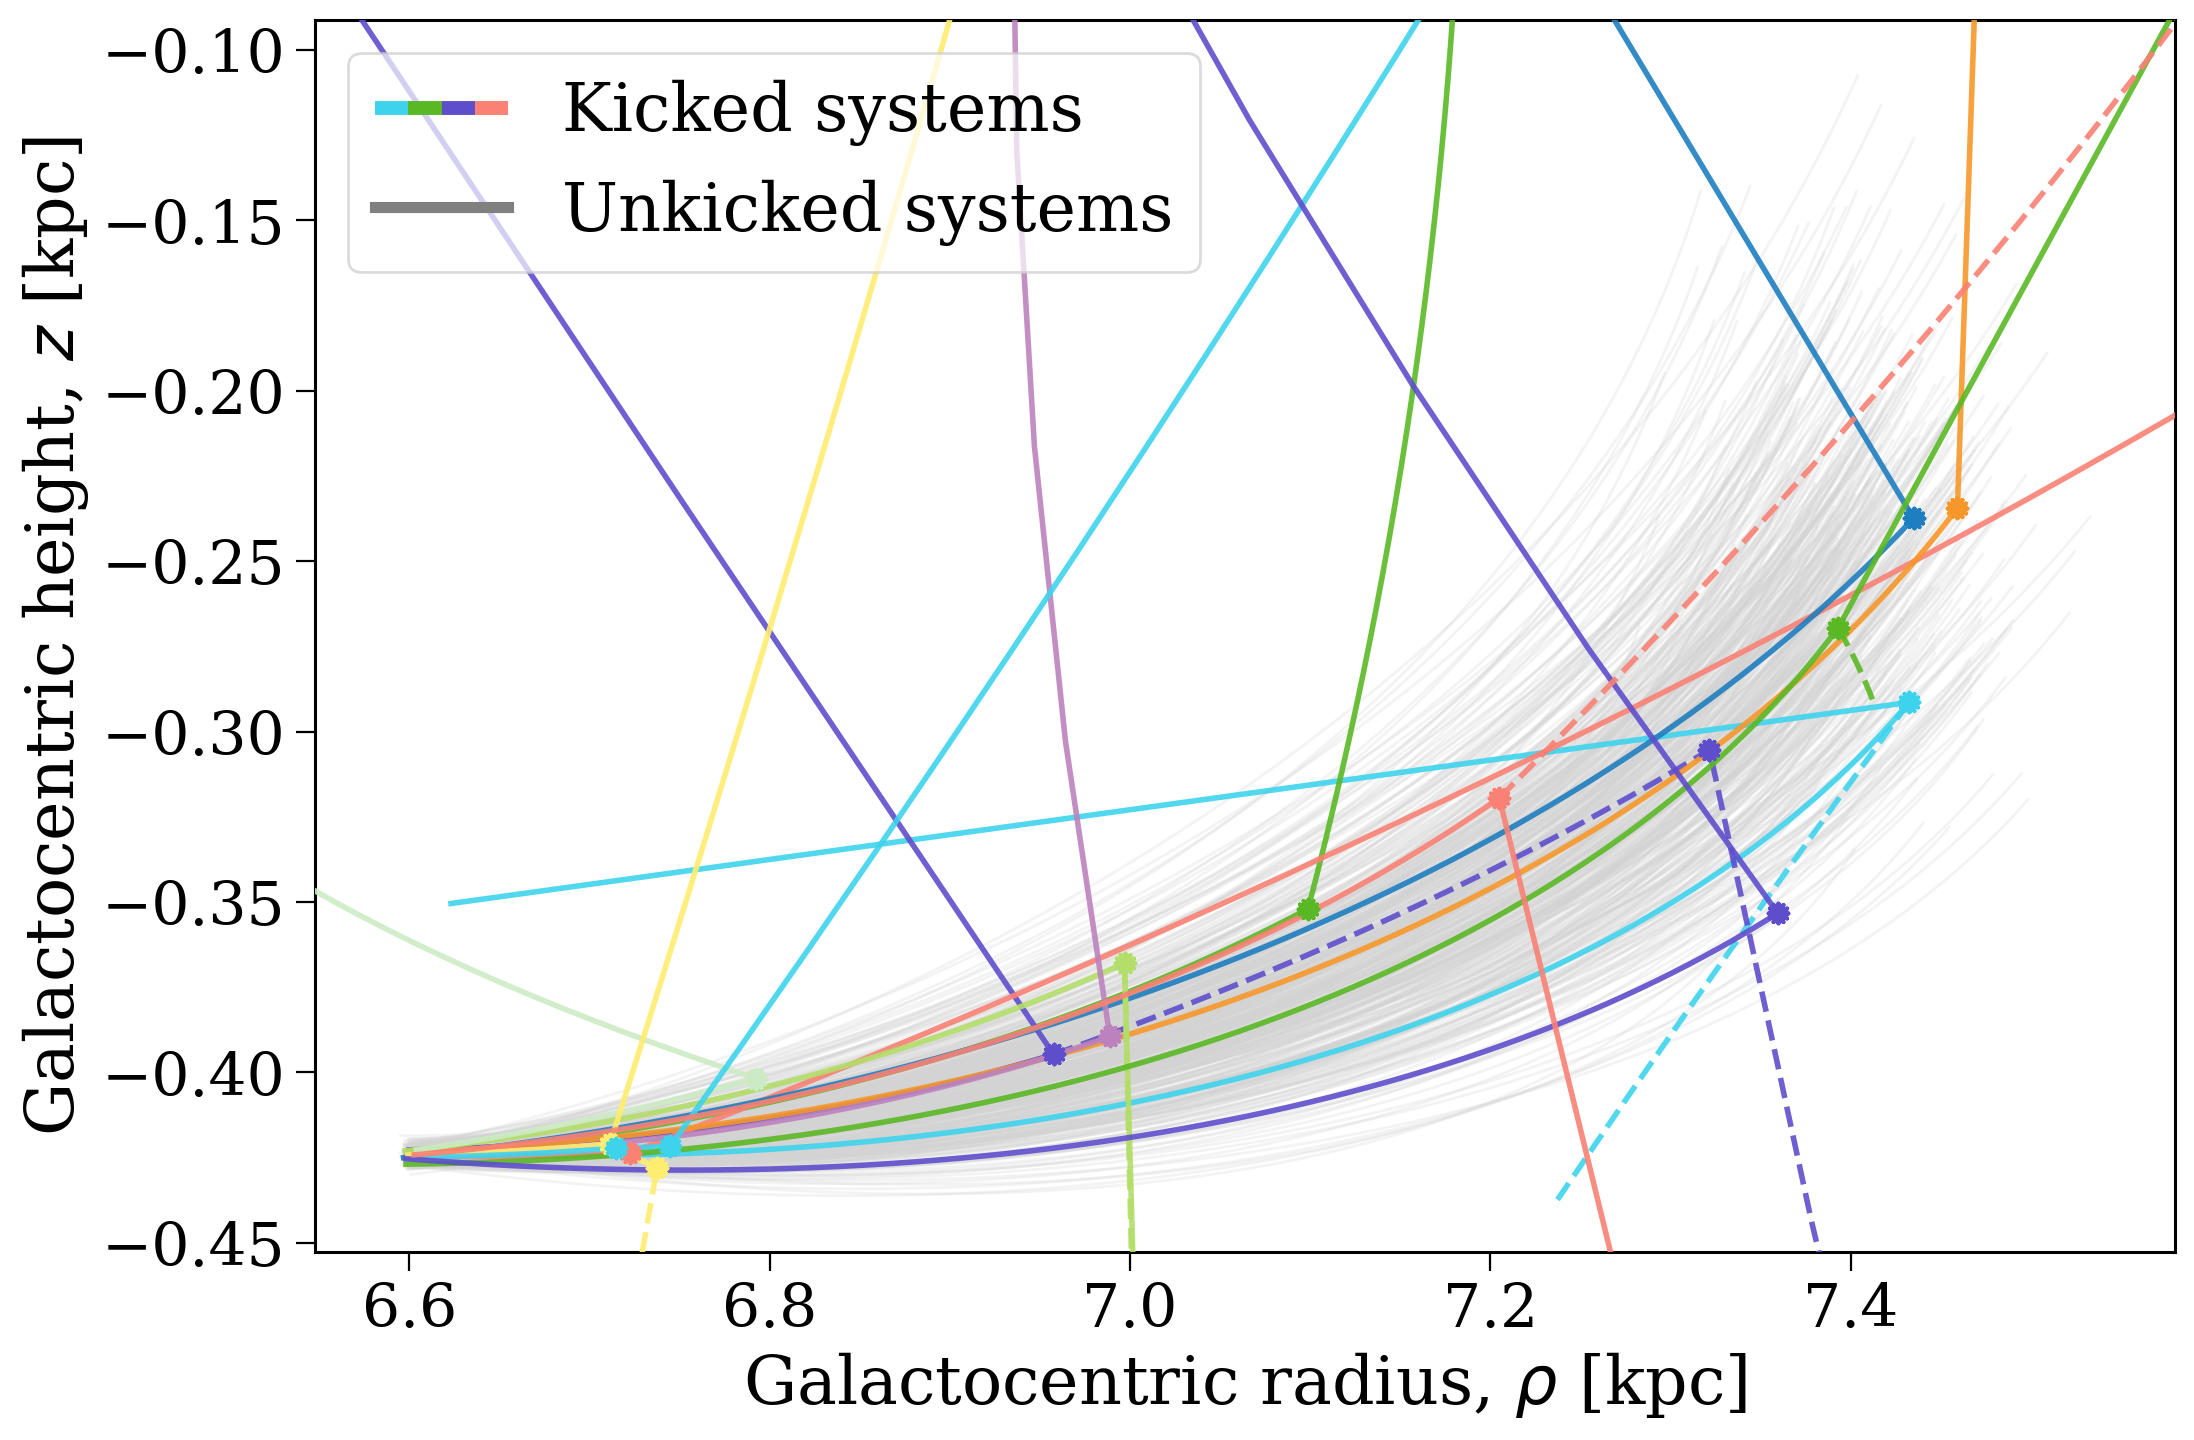

In [689]:
fig, ax = plot_cluster(p, kicked_limit=25, boring_limit=500)

### A curated subset

Now that's of course a little hard to interpret, so in a case of "here's one I made earlier", let's do this differently and use a couple of systems that I've picked out to illustrate some different scenarios.

Binary 720
  Ended as [[15. 13.]], with a separation of  0.00 Rsun
  Initial masses were [[10.63  7.41]] Msun
  Supernova occured at [32.77] Myr and separation was [0.] Rsun
  Natal kick strengths were [456.77   0.  ] km/s, v_sys_1 was [456.77   0.  ] km/s, and v_sys_2 was [0. 0.] km/s

Binary 1205
  Ended as [[13. 13.]], with a separation of -1.00 Rsun
  Initial masses were [[14.98  5.23]] Msun
  Supernova occured at [14.71 25.28] Myr and separation was [79.27 -1.  ] Rsun
  Natal kick strengths were [526.01 466.82] km/s, v_sys_1 was [551.17 551.17] km/s, and v_sys_2 was [ 32.25 491.21] km/s

Binary 1541
  Ended as [[13. 13.]], with a separation of -1.00 Rsun
  Initial masses were [[10.26  8.35]] Msun
  Supernova occured at [26.47 38.75] Myr and separation was [ 3.34799e+03 -1.00000e+00] Rsun
  Natal kick strengths were [827.71 433.02] km/s, v_sys_1 was [628.37 628.37] km/s, and v_sys_2 was [ 72.41 448.16] km/s

Binary 461
  Ended as [[13.  1.]], with a separation of -1.00 Rsun
  Initi

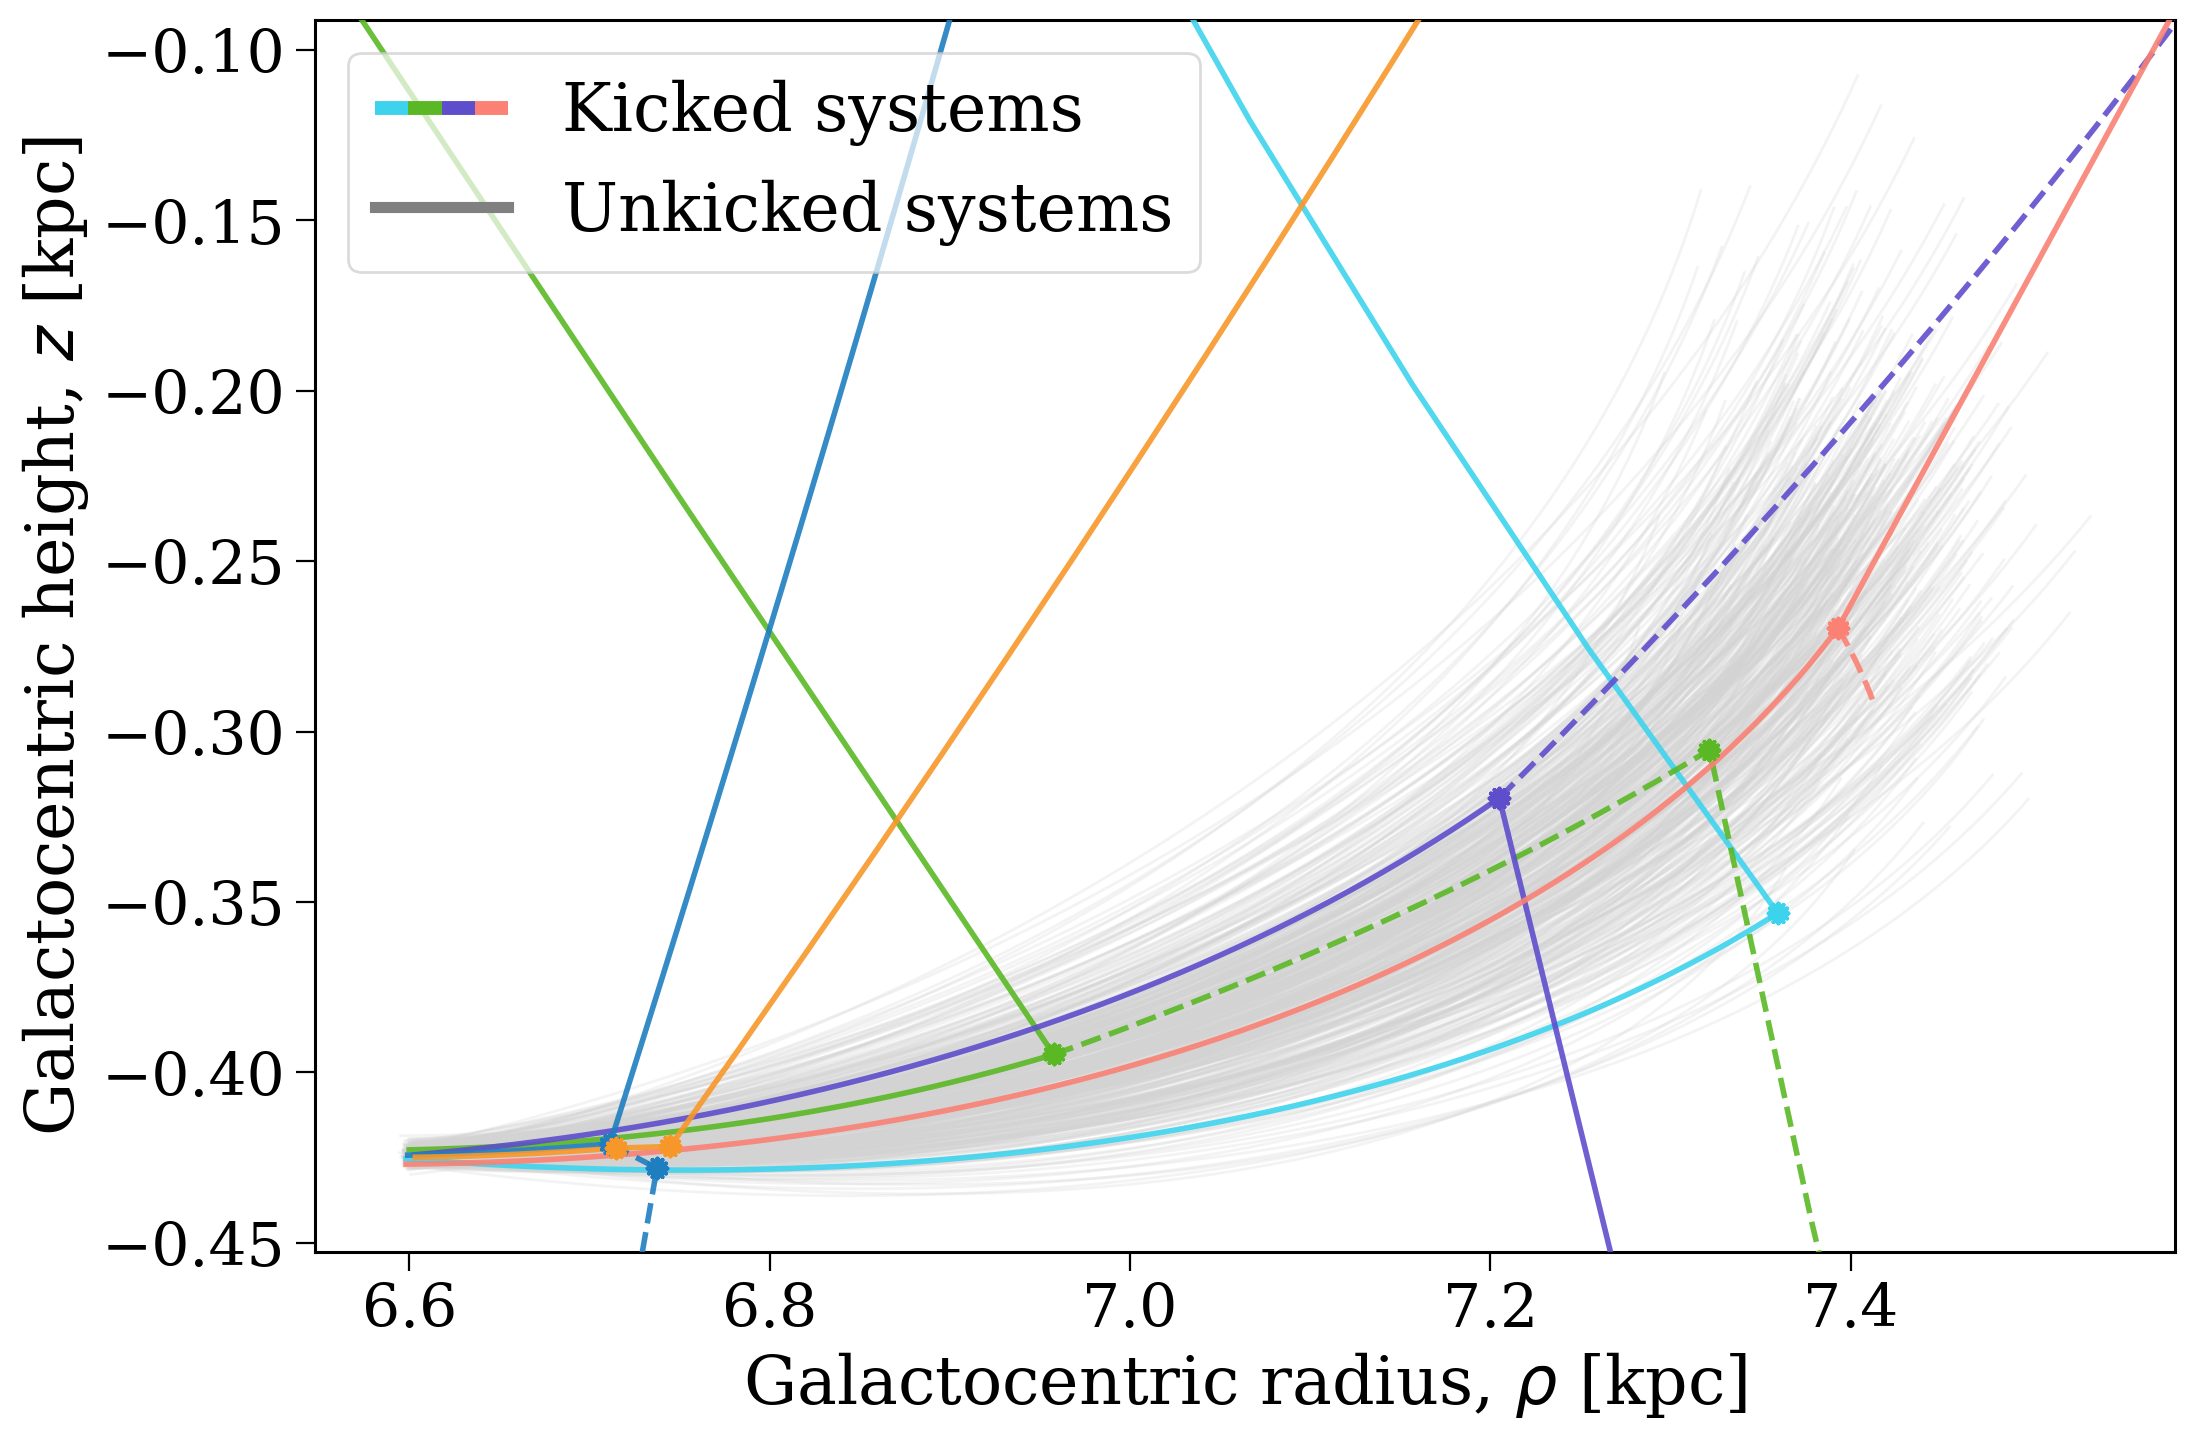

In [710]:
fig, ax = plot_cluster(p, kicked_limit=50, boring_limit=500,
                       manual_kicked_bin_nums=[720, 1205, 1541, 461, 2503, 1503], verbose=True)

Let's talk about the different scenarios that are occurring here:

- The earliest supernova shown occurs for the dark blue binary after $4 \, {\rm Myr}$ and disrupts the binary. The secondary travels a short distance before exploding $1 \, {\rm Myr}$ later and being ejected from the cluster in almost the opposite direction to the primary.
- The orange binary follows a very similar timeline of supernovae explosions. However, this binary has a much tighter orbit at the moment of each supernova (and thus a higher binding energy). Additionally, both supernova result in much weaker natal kicks than those in the dark blue binary. This means that the orange binary survives without disrupting and is ejected from the cluster as a binary black hole after the second supernova.
- Later during the cluster evolution the green binary is immediately disrupted after the first supernova, with the newly formed neutron star rapidly exiting the cluster. Yet, due to the wide separation at the moment of the supernova, the orbital velocity of the secondary (which determines its ejection velocity) is very low. This means that it remains bound to the cluster for the subsequent $11 \, {\rm Myr}$ of its evolution, until its own supernova.
- The purple and red binaries each immediately unbind after the first supernova and both stars are ejected from the cluster. We highlight that in the case of the purple binary, the secondary is ejected at such a high velocity that its supernova occurs more than $500 \, {\rm pc}$ from the parent cluster.
- Finally, for the light blue binary, after ${\sim}30 \, {\rm Myr}$, the secondary star expands during core helium burning and overflows its Roche lobe, causing unstable mass transfer which leads to a merger. The merged star then later reaches supernova and formed a neutron star which is ejected from the cluster by its natal kick.

### A pretty version

And finally, just for fun, we can make a version of the plot in dark mode that has some fake stars in the background :star:

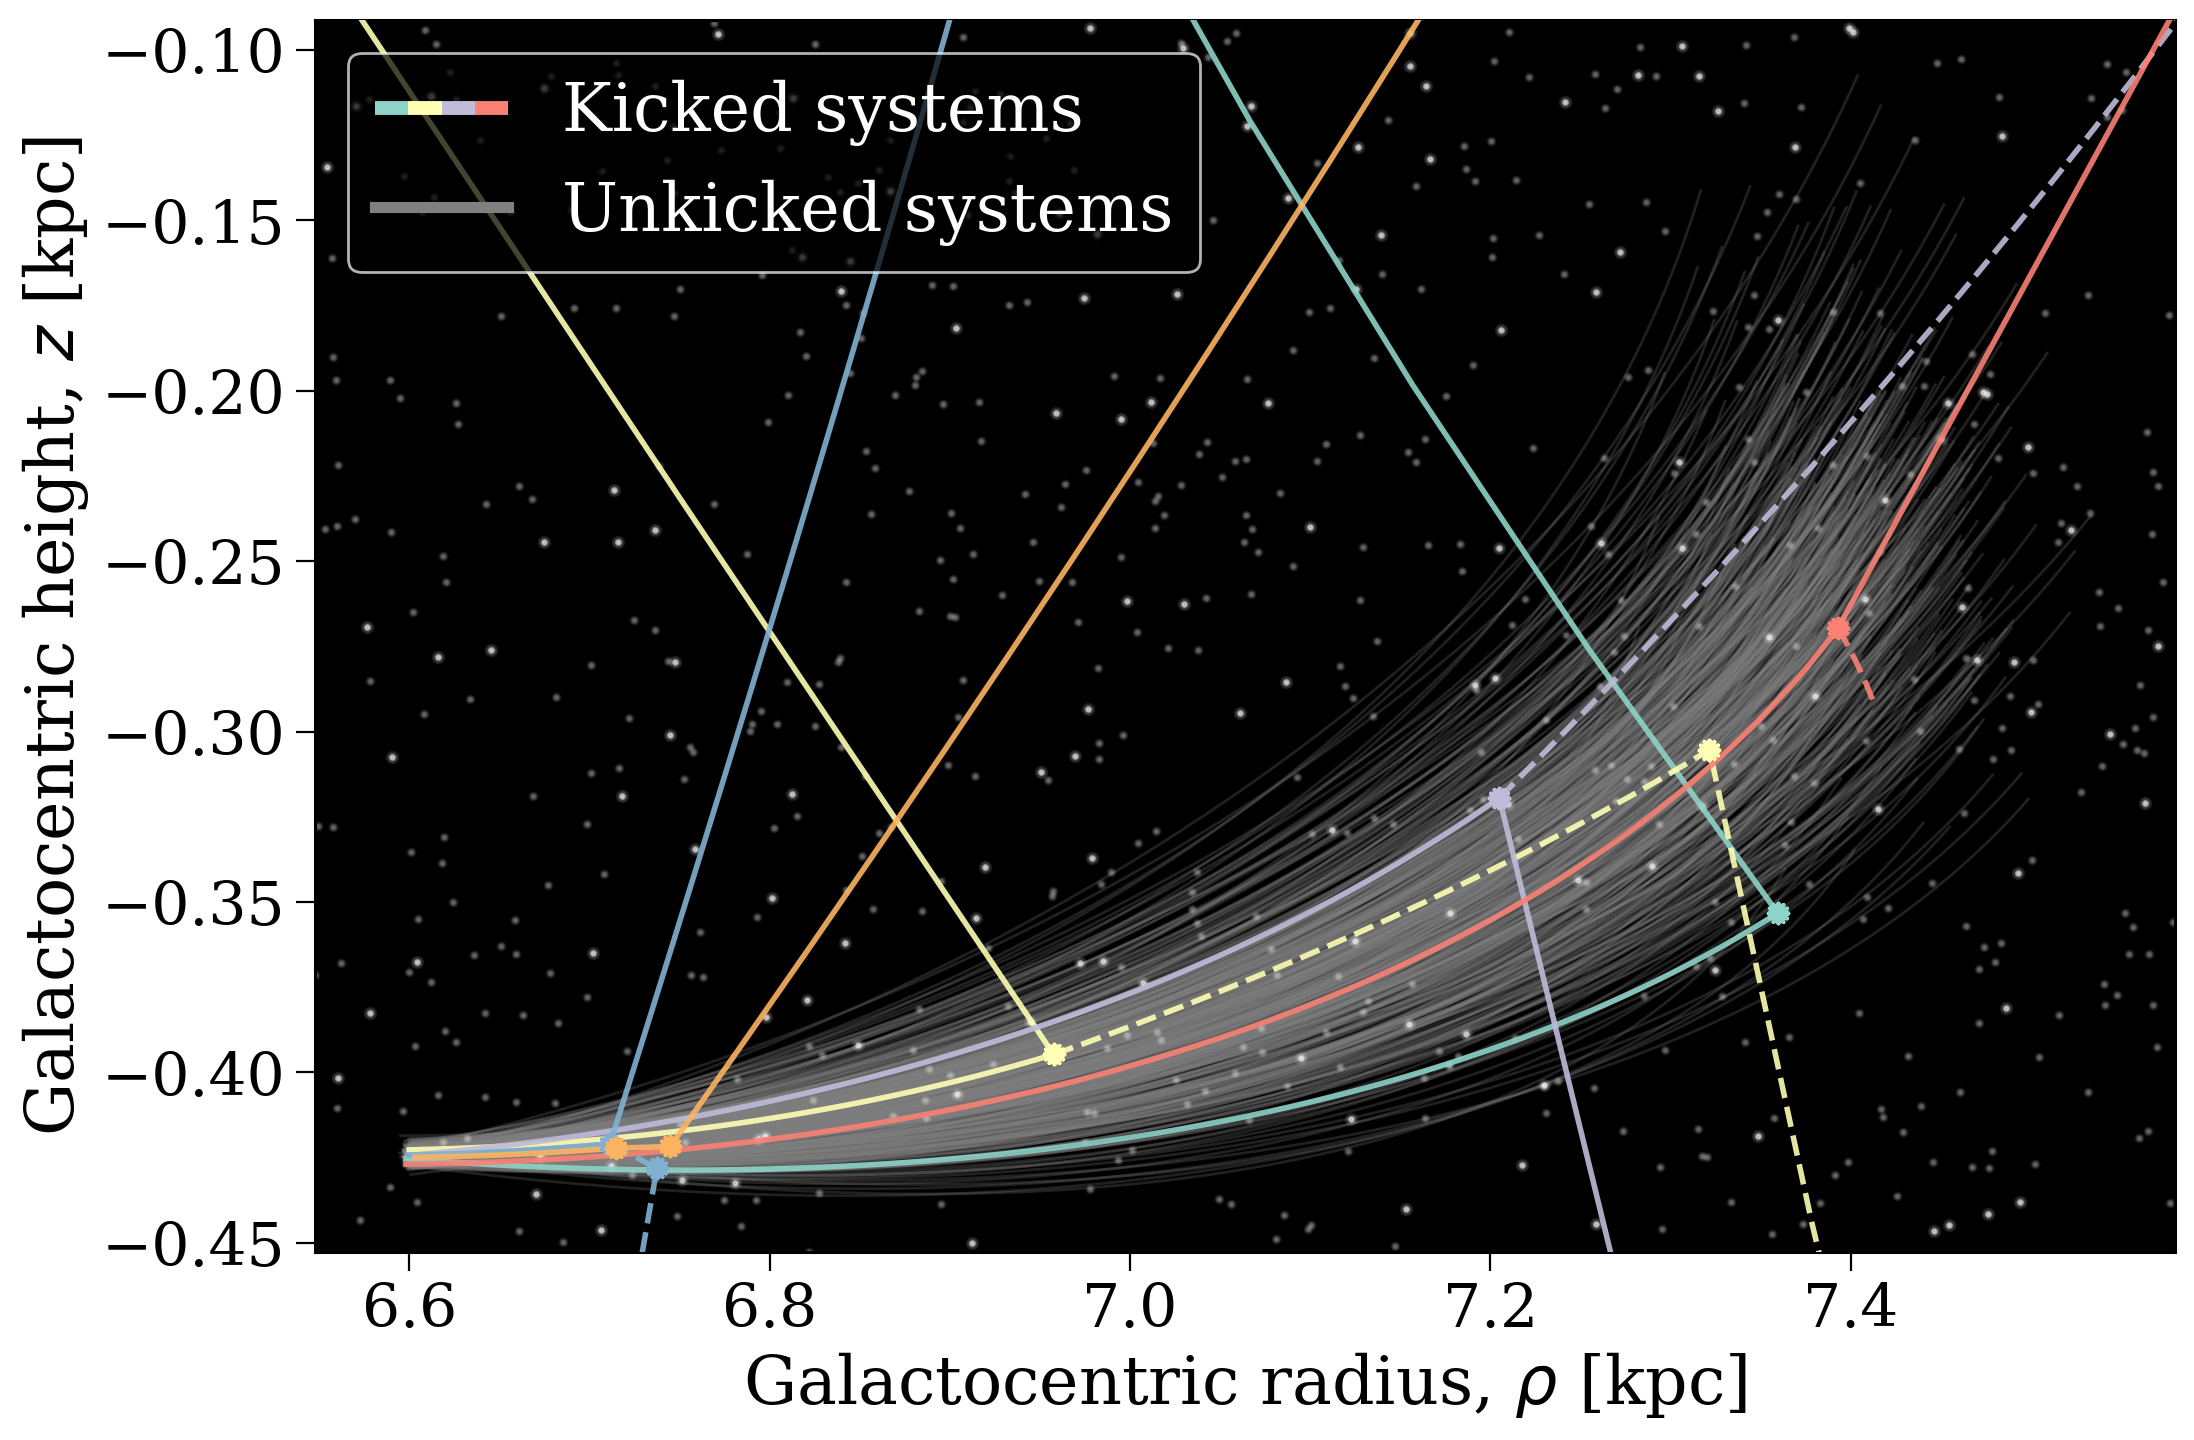

In [694]:
fig, ax = plot_cluster(p, dark_mode=True, show_stars=True, kicked_limit=50, boring_limit=500,
                       manual_kicked_bin_nums=[720, 1205, 1541, 461, 2503, 1503])